In [1]:
import cv2 
import time
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.preprocessing import StandardScaler
import matplotlib.image as mpimg
from skimage.feature import hog
import glob
%matplotlib inline
from lesson import *

Data Exploration: to show the hog features and images

/Users/HJK-BD/.pyenv/versions/3.5.2/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


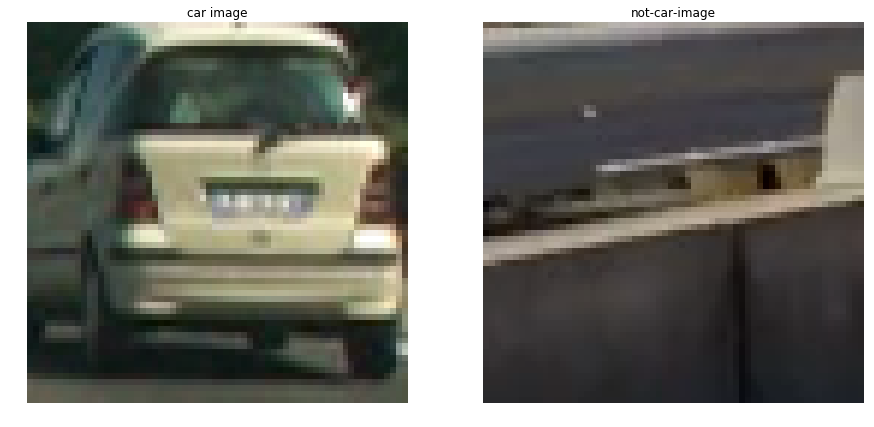

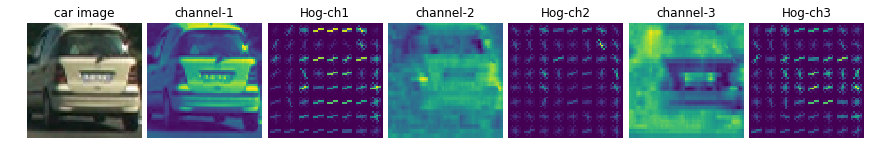

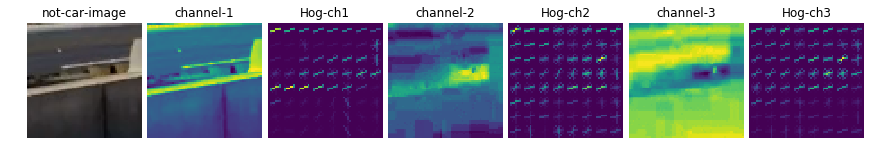

In [2]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block

carpath = 'images/vehicles/*/*.png'
noncarpath = 'images/non-vehicles/*/*.png'
cars = [imgpath for imgpath in glob.glob(carpath)]
notcars = [imgpath for imgpath in glob.glob(noncarpath)]
ind = np.random.randint(0,len(cars))
imgs = [cars[ind], notcars[ind]]
titles = ['car image','not-car-image']

f, ax = plt.subplots(1, 2, figsize=(15,12))
ax[0].imshow(mpimg.imread(imgs[0]));
ax[0].set_title(titles[0])
ax[0].axis('off')   
ax[1].imshow(mpimg.imread(imgs[1]));
ax[1].set_title(titles[1])
ax[1].axis('off')  

# #plot the images
for i,img in  enumerate(imgs):
    f, ax = plt.subplots(1, 7,figsize=(15,10))
    f.subplots_adjust(hspace=0.2, wspace=0.05)
    img = mpimg.imread(img)
    ax[0].imshow(img);
    ax[0].set_title(titles[i])
    ax[0].axis('off')
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    for channel in range(img.shape[2]):
        nindex = 1+channel*2
        ax[nindex].imshow(img[:,:,channel])
        title = "channel-{0}".format(channel+1)
        ax[nindex].set_title(title)
        ax[nindex].axis('off')
        feature,image = get_hog_features(img[:,:,channel], orient, pix_per_cell, cell_per_block, 
                            vis=True, feature_vec=True)
        title = "Hog-ch{0}".format(channel+1)
        ax[nindex+1].imshow(image)
        ax[nindex+1].set_title(title)
        ax[nindex+1].axis('off')

In [3]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, y_start_stop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
#     draw_img = np.copy(img)
    xstart = 300
    ystart, ystop = y_start_stop[0], y_start_stop[1]
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,xstart:-1,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
#     print('ch1 shape: ', ch1.shape)
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
#     print('nxblocks: ',nxblocks)
#     print('nyblocks: ',nyblocks)
#     print('nblocks_per_window: ', nblocks_per_window)
#     print('nfeat_per_block: ',nfeat_per_block)
#     print('nblocks_per_window: ',nblocks_per_window)
#     print('nxsteps: ',nxsteps)
#     print('nysteps: ',nysteps)
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
#     print('hog1 shape: ', hog1.shape)
#     print('nblocks_per_window: ', nblocks_per_window)
    all_windows = []
    hot_windows = []
    for xb in range(nxsteps+1):
        for yb in range(nysteps+1):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            #print(spatial_features.shape, hist_features.shape, hog_features.shape)
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            
            all_windows.append([(xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart)])
            if test_prediction == 1:
#                 cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                hot_windows.append([(xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart)])
    return all_windows, hot_windows


from scipy.ndimage.measurements import label
##add heapmap
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def minus_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] -= 1
#         if heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] < 0:
    heatmap[heatmap<0] = 0
    
    # Return updated heatmap
    return heatmap

##If your classifier is working well, then the "hot" parts of the map are where the cars are, 
##and by imposing a threshold, you can reject areas affected by false positives. So let's write
##a function to threshold the map as well.
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [4]:
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

print('type of svc: ', type(svc))
print('orient: ', orient)
print('pix_per_cell: ', pix_per_cell)
print('cell_per_block: ',cell_per_block)
print('spatial_size: ', spatial_size)
print('hist_bins: ', hist_bins)

type of svc:  <class 'sklearn.svm.classes.LinearSVC'>
orient:  9
pix_per_cell:  8
cell_per_block:  2
spatial_size:  (16, 16)
hist_bins:  32


In [5]:
files = glob.glob('test_images/testvideo*.jpg')
# f,ax = plt.subplots(2,3, figsize=(15,15))
found_images = []
found_hot_windows = []
print(files[0])
for ind, file in enumerate(files):
    image = mpimg.imread(file)
    t = time.time()
#     scales = [1,1.5,2,2.5]
#     y_start_stop = [(400,600),(400,600),(450,600),(400,500)]
    scales = [1,1.2,1.5]
    y_start_stop = [(400,480),(400,500),(400,550)]
    hot_windows = []
    all_windows = []
    color = [(255,0,0),(0,255,0),(0,0,255)]
    for i,scale in enumerate(scales):
        all_areas,hot_areas = find_cars(image, y_start_stop[i], scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)                  
        hot_windows += hot_areas
        all_windows.append([all_areas,color[i]])
    found_hot_windows.append(hot_windows)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to find cars...')

    out_img = draw_boxes(image, hot_windows)
    out_img2 = draw_boxes2(image, all_windows)
    found_images.append(out_img)
# plt.figure(figsize=(20,15))
# plt.imshow(out_img2)

test_images/testvideo710.jpg


/Users/HJK-BD/.pyenv/versions/3.5.2/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


0.58 Seconds to find cars...
0.54 Seconds to find cars...
0.61 Seconds to find cars...
0.58 Seconds to find cars...
0.57 Seconds to find cars...
0.56 Seconds to find cars...


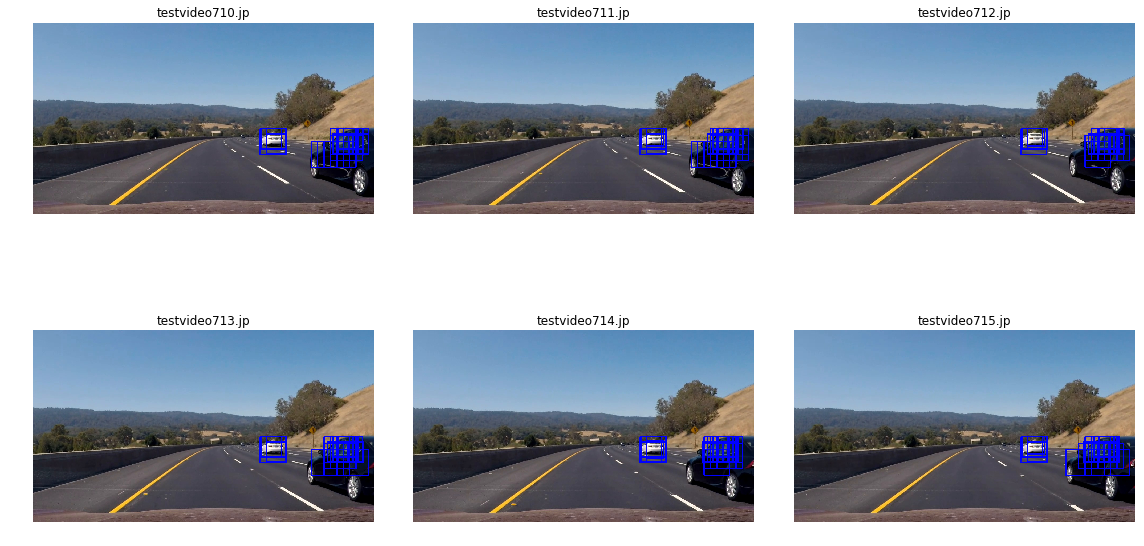

In [6]:
f = plt.figure(figsize=(16,9))
for ind, out_img in enumerate(found_images):
    file = files[ind]
    ax = plt.subplot(2,3,ind+1)
    ax.imshow(out_img)
    ax.set_title(file[file.index('/')+1:-1])
    ax.axis('off')
#     ax.set_aspect('equal')
    plt.subplots_adjust(wspace=0, hspace=None)
# plt.show()
plt.tight_layout()

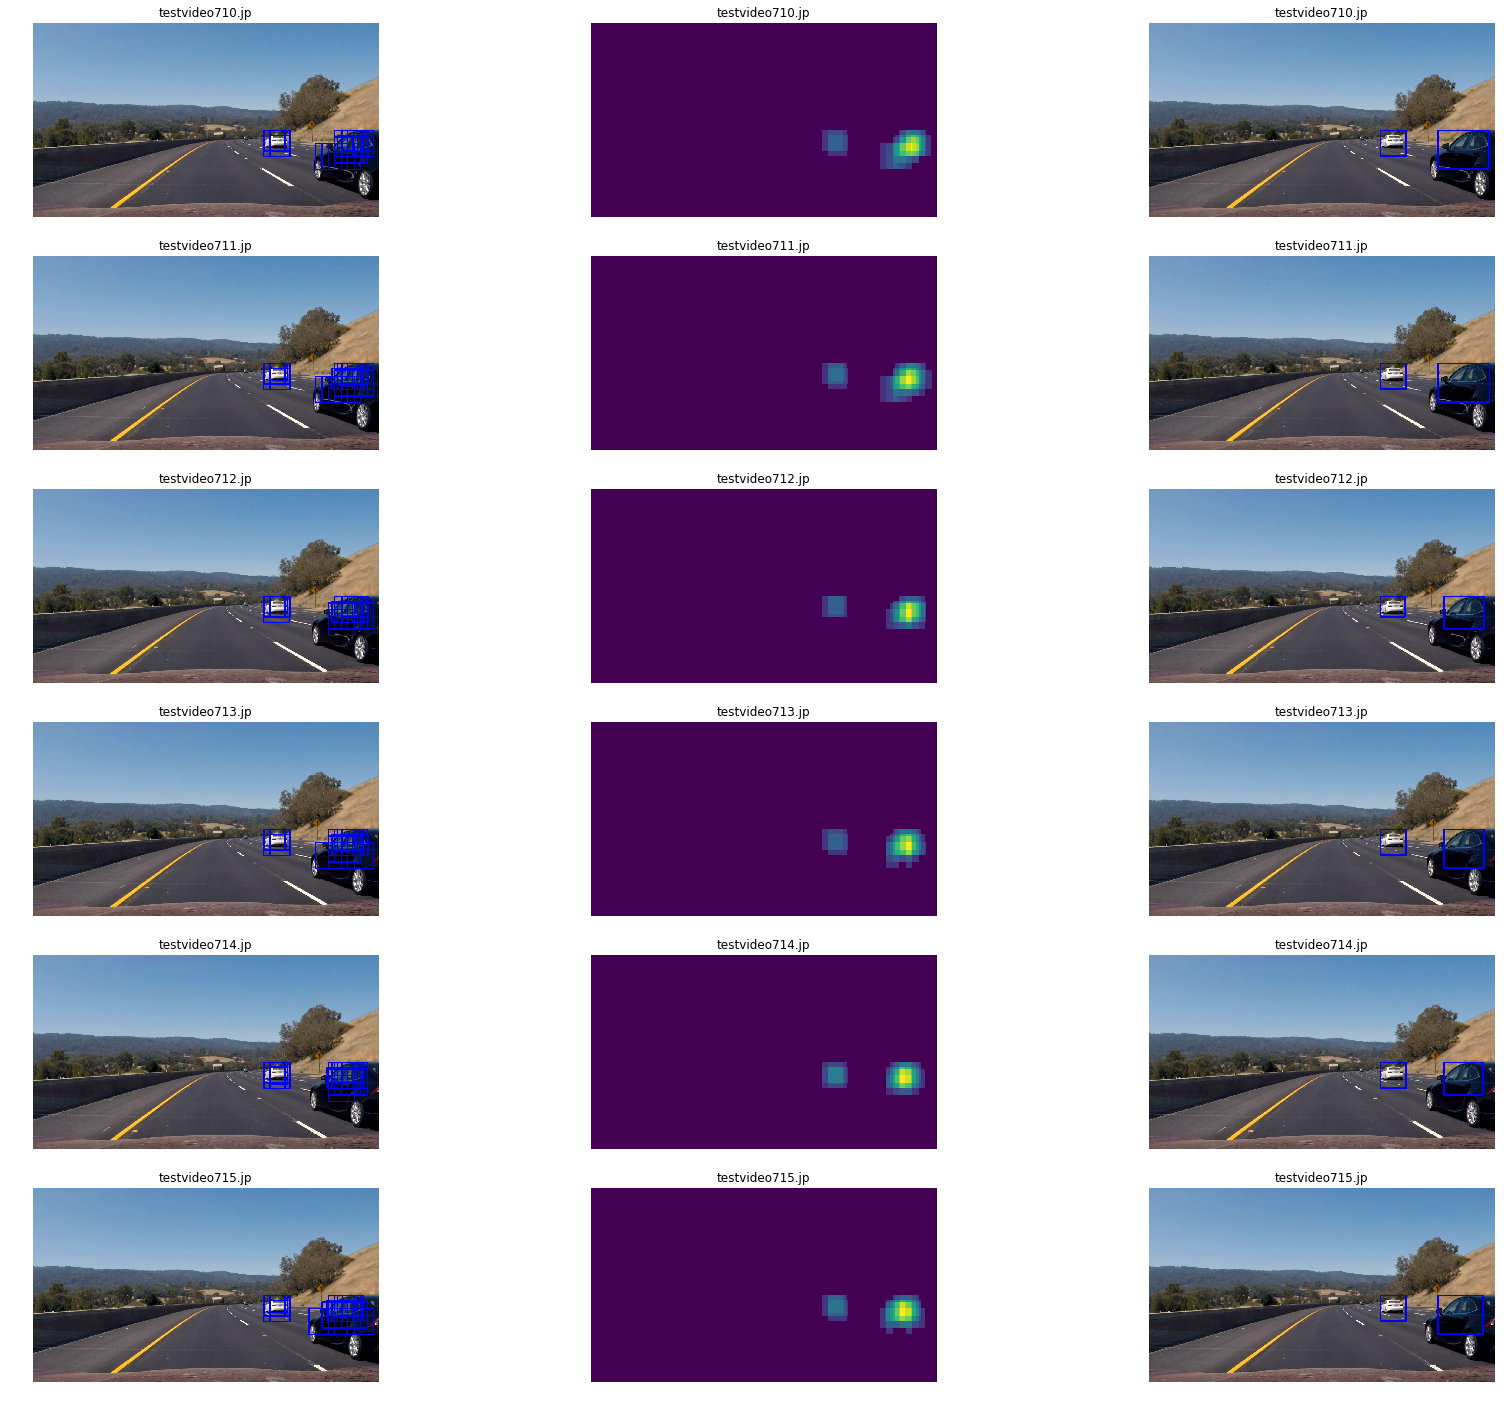

In [7]:
f = plt.figure(figsize=(30,25))
# for ind, image in enumerate(found_images):
for ind, file in enumerate(files):
    image = mpimg.imread(file)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,found_hot_windows[ind])
#     print(image.shape)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    ax = plt.subplot(6,3,3*ind+1)
    ax.imshow(found_images[ind])
    ax.set_title(file[file.index('/')+1:-1])
    ax.axis('off')
    ax = plt.subplot(6,3,3*ind+2)
    ax.imshow(heatmap)
    ax.set_title(file[file.index('/')+1:-1])
    ax.axis('off')
    ax = plt.subplot(6,3,3*ind+3)
    ax.imshow(draw_img)
    ax.set_title(file[file.index('/')+1:-1])
    ax.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0.2)

### Implementation in videos with filtering
I used a global queue variable **allsaved** with size **nframe** to save the previous hot windows up to **nframe** ,and added all the values in these hot windows as the hot window for the current frame, and then apply threshold function with threshold value equal to the value of nframe. If new frame comes and the queue is already full, so the first element of the queue will be poped out and replaced by the most recent hot window, and the sum of values of all hot windows needs to be recalculated again. In this way, the transition between detected boxes is much more smoother than the one with no window filtering technique. Besides that, I choose to process every other images in the video to speed up the processing time.

In [10]:
count = 0
nframe = 15
# I am going to save 2 frames in a list, and then average them
allsaved = []
savedheat = None
pre = None
def process_image(image):
    global count, pre, allsaved, savedheat
    return_img = image
#     if (count>700): return image
    if count %2 == 0:
        scales = [1,1.25,1.5]
        y_start_stop = [(400,500),(400,500),(400,550)]
        hot_windows = []
        #find all scales
        for i,scale in enumerate(scales):
            all_areas,hot_areas = find_cars(image, y_start_stop[i], scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)                  
            hot_windows += hot_areas
        # if hot_windows less than
        if savedheat is None:
            savedheat = np.zeros_like(image[:,:,0]).astype(np.float)
        if len(allsaved)==nframe:
            savedheat = minus_heat(savedheat, allsaved[0])
            allsaved.pop(0)
        allsaved.append(hot_windows)
        heat = savedheat
        #heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
        heat = add_heat(heat,hot_windows)
        savedheat = np.copy(heat)
        # Apply threshold to help remove false positives
        heat = apply_threshold(heat, len(allsaved))
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)
        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(image), labels)
        pre = draw_img
        return_img =  draw_img
    else:
        return_img = pre
    count += 1
    return return_img
    #plt.imshow(draw_img)
# image = mpimg.imread('test_images/test6.png')
# image = mpimg.imread('test_images/testvideo710.jpg')
# image = mpimg.imread('name.png')
# draw_img = process_image(image)
# plt.imshow(draw_img)
# f = plt.figure()
# labels = label(heatmap)
# print(labels[1], 'cars found')
# plt.imshow(labels[0], cmap='gray')
# plt.show()

In [9]:
#Test on the vdieos
from moviepy.editor import VideoFileClip
from IPython.display import HTML
test_video = 'project_video.mp4'
output = 'output.mp4'
clip1 = VideoFileClip(test_video)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [06:57<00:00,  2.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 6min 19s, sys: 22.3 s, total: 6min 41s
Wall time: 6min 59s


In [16]:
HTML("""
<video width="100%" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

### Yolo comparison

It would be interesting to compare this model with the existing deep learning based detection framework Yolo.[This](https://medium.com/@xslittlegrass/almost-real-time-vehicle-detection-using-yolo-da0f016b43de) has very good introduction on how to build a tiny Yolo model and use the already-trained yolo model parameters to predict objects on the images. A complete explanation on the Yolo model is avaiable in the [web](https://pjreddie.com/darknet/yolo/). Below is an example of image detection by Yolo.

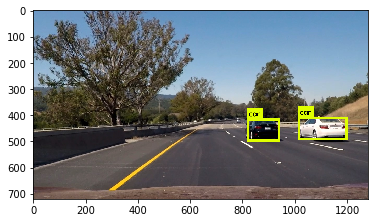

In [15]:
image = mpimg.imread('output_images/predictions.png')
plt.imshow(image)

Here below is also the Yolo prediction on the video without any filtering applied.

In [17]:
HTML("""
<video width="100%" height="540" controls>
  <source src="{0}">
</video>
""".format("out_yolo.mp4"))

As it can be seen from the above videos, Yolo gives better detection on the size of the bounding boxes around the objects. The above SVM+HOG approach also gives good detection on object but the box size is larger than the actual ones. The drawback for Yolo is that the model is very difficult to train and it takes much more time to process the video if GPU is not available.